# System Dynamics
# EGR 557 Foldable Robotics
# Team 7

In [ ]:
# RUN PIP INSTALL CODE BLOCK

# Install standard packages...
!pip install meshio pygmsh ezdxf pandoc-fignos pandoc-eqnos pypdf4 service_identity ftd2xx pygithub twine paho-mqtt
!pip install ntplib pygame pysftp pyserial

# Install foldable-robotics-specific packages.
!pip install pypoly2tri idealab_tools foldable_robotics pynamics

In [ ]:
# import pachages
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
import pynamics.integration
import sympy
import numpy
import matplotlib.pyplot as plt
plt.ion()
from math import pi
#from pynamics.constraint import Constraint
import scipy.optimize


In [ ]:
global_q = True
use_constraints = False

# Create Pynamic system
system = System()
pynamics.set_system(__name__,system)

# Define constants and variables

g = Constant(9.81,'g',system)
b = Constant(0,'b',system)
k = Constant(0,'k',system)

preload1 = Constant(90*pi/180,'preload1',system)
preload2 = Constant(0*pi/180,'preload2',system)
preload3 = Constant(-90*pi/180,'preload3',system)

# Integration tolerance
tol = 1e-12

# Time
tinitial = 0
tfinal = 10
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

# Differential state variables
qA,qA_d,qA_dd = Differentiable('qA',system)
qB,qB_d,qB_dd = Differentiable('qB',system)
qC,qC_d,qC_dd = Differentiable('qC',system)

# Initial values
initialvalues = {}
initialvalues[qA]=120*pi/180
initialvalues[qA_d]=0*pi/180
initialvalues[qB]=0*pi/180
initialvalues[qB_d]=0*pi/180
initialvalues[qC]=-60*pi/180
initialvalues[qC_d]=0*pi/180

statevariables = system.get_state_variables()
ini = [initialvalues[item] for item in statevariables]

# Define frames and frames rotations
N = Frame('N')
A = Frame('A')
B = Frame('B')
C = Frame('C')

system.set_newtonian(N)

if not global_q:
    A.rotate_fixed_axis_directed(N,[0,0,1],qA,system)
    B.rotate_fixed_axis_directed(A,[0,0,1],qB,system)
    C.rotate_fixed_axis_directed(B,[0,0,1],qC,system)
else:
    A.rotate_fixed_axis_directed(N,[0,0,1],qA,system)
    B.rotate_fixed_axis_directed(N,[0,0,1],qB,system)
    C.rotate_fixed_axis_directed(N,[0,0,1],qC,system)

### 1. Scale: Ensure your system is using SI units. You should be specifying lengths in meters (so millimeters should be scaled down to the .001 range), forces in Newtons, and radians (not degrees), and masses in kg. You may make educated guesses about mass for now.

| Link | Length (m) | Mass (kg) |
|------|--------|------|
|  lA   |  0.06  |  0.01  |
|  lB   |  0.018  |  0.03  |
|  lC   |  0.06  |  0.01  |


The lengths of each links are obtain from our kinematic design. The masses are just estimated values for now. More accurate values will be provided after a Solidworks model is built.

In [ ]:
# Define constants and vaiables
lA = Constant(0.06,'lA',system)
lB = Constant(0.18,'lB',system)
lC = Constant(0.06,'lC',system)
lD = Constant(0.03,'lD',system)

mA = Constant(0.01,'mA',system)
mB = Constant(0.03,'mB',system)
mC = Constant(0.01,'mC',system)

# Define kinematics
pNA = 0*N.x + 0*N.y
pAB = pNA + lA*A.x
pBtip = pAB + lB*B.x
pBC = pAB + lD*B.x
pCD = pBC + lC*C.x

points = [pNA,pAB,pBtip,pBC,pCD]

### 2. Define Inertias: Add a center of mass and a particle or rigid body to each rotational frame. You may use particles for now if you are not sure of the inertial properties of your bodies, but you should plan on finding these values soon for any “payloads” or parts of your system that carry extra loads (other than the weight of paper).

For now, I just put inertia values as 1 for all of the bodies. More accurate values will be provided after a Solidworks model is built.
Since the main material of our device body is paper and its uniform, the center of mass is located at the center of the body.

In [ ]:
# Add inertia. In the following code, we use point mass before we have the more realistic values of inertia. Therefore, all inertial values are 1 for now.
Ixx_A = Constant(1,'Ixx_A',system)
Iyy_A = Constant(1,'Iyy_A',system)
Izz_A = Constant(1,'Izz_A',system)
Ixx_B = Constant(1,'Ixx_B',system)
Iyy_B = Constant(1,'Iyy_B',system)
Izz_B = Constant(1,'Izz_B',system)
Ixx_C = Constant(1,'Ixx_C',system)
Iyy_C = Constant(1,'Iyy_C',system)
Izz_C = Constant(1,'Izz_C',system)

# Center of mass
pAcm = pNA+lA/2*A.x
pBcm = pAB+lB/2*B.x
pCcm = pBC+lC/2*C.x

# Angular velocity
wNA = N.getw_(A)
wAB = A.getw_(B)
wBC = B.getw_(C)

# Define body
IA = Dyadic.build(A,Ixx_A,Iyy_A,Izz_A)
IB = Dyadic.build(B,Ixx_B,Iyy_B,Izz_B)
IC = Dyadic.build(C,Ixx_C,Iyy_C,Izz_C)

# BodyA = Particle(pAcm,mA,'ParticleA',system)
# BodyB = Particle(pBcm,mB,'ParticleB',system)
# BodyC = Particle(pCcm,mC,'ParticleC',system)
BodyA = Body('BodyA',A,pAcm,mA,IA,system)
BodyB = Body('BodyB',B,pBcm,mB,IB,system)
BodyC = Body('BodyC',C,pCcm,mC,IC,system)

# 3. Add Forces: Add the acceleration due to gravity. Add rotational springs in the joints (using k=0 is ok for now) and a damper to at least one rotational joint. You do not need to add external motor/spring forces but you should start planning to collect that data.

A damper is added at the input joint (pNA). Other joints are assumed to be fully free (no damping, and no spring).

Note that although we have damping and spring formulation in the code the values (b and k) are set to zero in the previous code.

In [ ]:
system.addforce(-b*wNA,wNA)

# Spring force
if not global_q:
    system.add_spring_force1(k,(qA-preload1)*N.z,wNA) 
    #system.add_spring_force1(k,(qB-preload2)*A.z,wAB)
    #system.add_spring_force1(k,(qC-preload3)*B.z,wBC)
else:
    system.add_spring_force1(k,(qA-preload1)*N.z,wNA) 
    #system.add_spring_force1(k,(qB-qA-preload2)*N.z,wAB)
    #system.add_spring_force1(k,(qC-qB-preload3)*N.z,wBC)
    
# Gravity force
system.addforcegravity(-g*N.y)

# 4. Constraints: Keep mechanism constraints in, but follow the pendulum example of double-differentiating all constraint equations. --- If you defined your mechanism as unattached to the Newtonian frame, add enough constraints so that it is fully attached to ground (for now). you will be eventually removing these constraints.

The last tip of the four bar mechanism (pCD) is fixed to the ground.

In [ ]:
# Define constraints

eq = []
eq.append(pCD.dot(N.x))
eq.append(pCD.dot(N.y))
eq_d=[(system.derivative(item)) for item in eq]
eq_dd=[(system.derivative(item)) for item in eq_d]

# 5. Solution: Add the code from the bottom of the pendulum example for solving for f=ma, integrating, plotting, and animating. Run the code to see your results. It should look similar to the pendulum example with constraints added, as in like a rag-doll or floppy

In [ ]:
f,ma = system.getdynamics()

func1,lambda1 = system.state_space_post_invert(f,ma,eq_dd,return_lambda = True)

states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))


2021-03-01 05:33:43,126 - pynamics.system - INFO - getting dynamic equations
2021-03-01 05:33:43,254 - pynamics.system - INFO - solving a = f/m and creating function
2021-03-01 05:33:43,256 - pynamics.system - INFO - substituting constrained in Ma-f.
2021-03-01 05:33:43,318 - pynamics.system - INFO - done solving a = f/m and creating function
2021-03-01 05:33:43,319 - pynamics.system - INFO - calculating function for lambdas
2021-03-01 05:33:43,320 - pynamics.integration - INFO - beginning integration
2021-03-01 05:33:43,322 - pynamics.system - INFO - integration at time 0000.00
2021-03-01 05:33:43,368 - pynamics.integration - INFO - finished integration


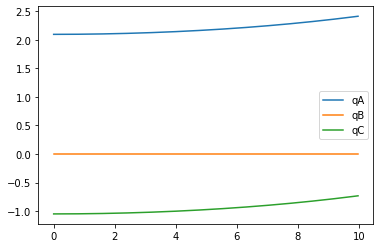

In [ ]:
# Plot --- output
plt.figure()
artists = plt.plot(t,states[:,:3])
plt.legend(artists,['qA','qB','qC'])

2021-03-01 05:33:43,606 - pynamics.output - INFO - calculating outputs
2021-03-01 05:33:43,623 - pynamics.output - INFO - done calculating outputs


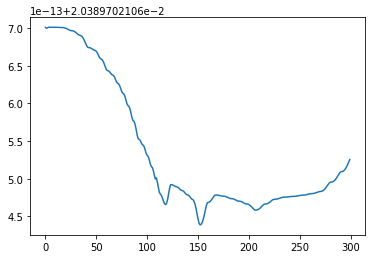

In [ ]:
# Plot --- energy

KE = system.get_KE()
PE = system.getPEGravity(pNA) - system.getPESprings()
energy_output = Output([KE-PE],system)
energy_output.calc(states)
energy_output.plot_time()

2021-03-01 05:33:43,822 - pynamics.output - INFO - calculating outputs
2021-03-01 05:33:43,836 - pynamics.output - INFO - done calculating outputs


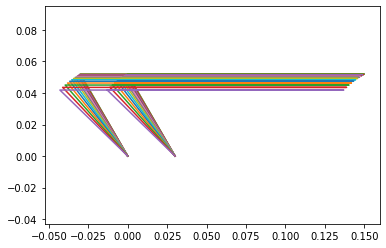

In [ ]:
# Motion

points = [pNA,pAB,pBtip,pBC, pCD]
points_output = PointsOutput(points,system)
y = points_output.calc(states)
points_output.plot_time(20)

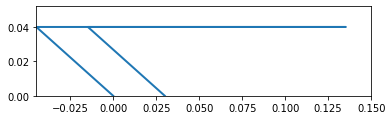

In [ ]:
points_output.animate(fps = 30,lw=2)

from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())


From the animation above, we see that because we set the neutral position of the device to stand straight (vertical sides for the four-bar mechanism), our device would not just freely drop to the ground. 

# 6. Tuning: Now adjust the damper value  to something nonzero, that over 10s shows that the system is settling.

2021-03-01 05:33:56,738 - pynamics.system - INFO - getting dynamic equations
2021-03-01 05:33:56,862 - pynamics.system - INFO - solving a = f/m and creating function
2021-03-01 05:33:56,864 - pynamics.system - INFO - substituting constrained in Ma-f.
2021-03-01 05:33:56,924 - pynamics.system - INFO - done solving a = f/m and creating function
2021-03-01 05:33:56,925 - pynamics.system - INFO - calculating function for lambdas
2021-03-01 05:33:56,926 - pynamics.integration - INFO - beginning integration
2021-03-01 05:33:56,928 - pynamics.system - INFO - integration at time 0000.00
2021-03-01 05:33:56,996 - pynamics.integration - INFO - finished integration


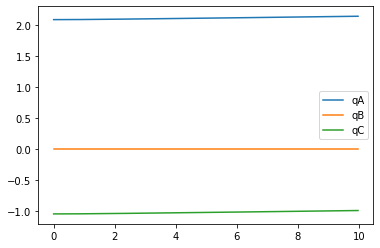

In [ ]:
b = Constant(1e0,'b',system)
system.addforce(-b*wNA,wNA)

f,ma = system.getdynamics()
func1,lambda1 = system.state_space_post_invert(f,ma,eq_dd,return_lambda = True)
states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

# Plot --- output
plt.figure()
artists = plt.plot(t,states[:,:3])
plt.legend(artists,['qA','qB','qC'])

2021-03-01 05:33:57,222 - pynamics.output - INFO - calculating outputs
2021-03-01 05:33:57,232 - pynamics.output - INFO - done calculating outputs


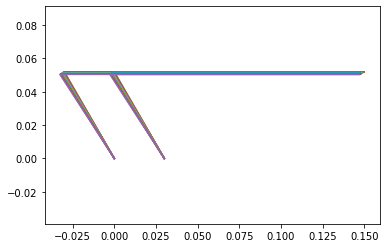

In [ ]:
# Motion

points = [pNA,pAB,pBtip,pBC, pCD]
points_output = PointsOutput(points,system)
y = points_output.calc(states)
points_output.plot_time(20)

# 7. (Optional): Adjust joint stiffness values so that your system looks more realistic.

2021-03-01 05:35:09,713 - pynamics.system - INFO - getting dynamic equations
2021-03-01 05:35:09,840 - pynamics.system - INFO - solving a = f/m and creating function
2021-03-01 05:35:09,843 - pynamics.system - INFO - substituting constrained in Ma-f.
2021-03-01 05:35:09,910 - pynamics.system - INFO - done solving a = f/m and creating function
2021-03-01 05:35:09,911 - pynamics.system - INFO - calculating function for lambdas
2021-03-01 05:35:09,912 - pynamics.integration - INFO - beginning integration
2021-03-01 05:35:09,914 - pynamics.system - INFO - integration at time 0000.00
2021-03-01 05:35:10,212 - pynamics.system - INFO - integration at time 0005.59
2021-03-01 05:35:10,522 - pynamics.system - INFO - integration at time 0009.47
2021-03-01 05:35:10,576 - pynamics.integration - INFO - finished integration


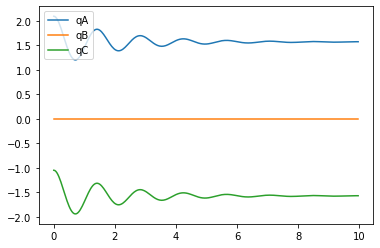

In [ ]:
k = Constant(1e1,'k',system)

# Spring force
if not global_q:
    system.add_spring_force1(k,(qA-preload1)*N.z,wNA) 
else:
    system.add_spring_force1(k,(qA-preload1)*N.z,wNA) 

f,ma = system.getdynamics()
func1,lambda1 = system.state_space_post_invert(f,ma,eq_dd,return_lambda = True)
states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

# Plot --- output
plt.figure()
artists = plt.plot(t,states[:,:3])
plt.legend(artists,['qA','qB','qC'])

2021-03-01 05:35:15,432 - pynamics.output - INFO - calculating outputs
2021-03-01 05:35:15,449 - pynamics.output - INFO - done calculating outputs


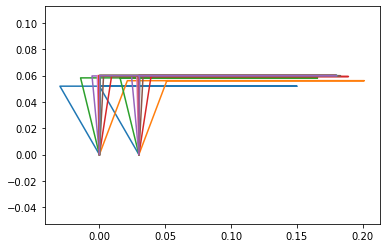

In [ ]:
# Motion

points = [pNA,pAB,pBtip,pBC, pCD]
points_output = PointsOutput(points,system)
y = points_output.calc(states)
points_output.plot_time(20)

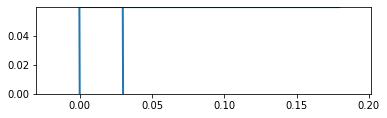

In [ ]:
points_output.animate(fps = 30,lw=2)

from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())